In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl


FONT_SIZE = 16
AXES_SIZE = FONT_SIZE * 1.5
TICK_SIZE = FONT_SIZE * 1.25
LEGEND_SIZE = FONT_SIZE

my_rcParams = {
    "axes.spines.top": False,
    "axes.spines.right": False,
    "lines.linewidth": 5,
    "font.size": FONT_SIZE,
    "font.family": "Helvetica",
    "axes.titlesize": AXES_SIZE,
    "axes.labelsize": AXES_SIZE,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "xtick.major.pad": FONT_SIZE / 2,
    "ytick.major.pad": FONT_SIZE / 2,
}

for k, v in my_rcParams.items():
    mpl.rcParams[k] = v

## Country-specific sequences per week

In [3]:
plot_df = pd.read_csv("../data/down_scaled/weekly_sequences_by_country.tsv", sep="\t")
plot_countries = ["USA", 
                  "Japan", 
                  "United Kingdom", "France", 
                  "Germany", 
                  "Mexico",
                  "Colombia",
                  "Chile",
                  "Argentina",
                  "China", "Australia", 
                  "Brazil", "South Africa",
                  "Nigeria",
                  "Ghana",
                  "Senegal",
                  "Egypt",
                  "Morocco",
                  "South Korea",
                  "Vietnam",
                  "Philippines",
                  "Singapore",
                  "Malaysia",
                  "India",
                  "Pakistan",
                  "Spain",
                  "Portugal",
                  "Denmark",
                  "Monaco"]
_plot_df = plot_df[plot_df.country.isin(plot_countries)]

In [4]:
THRESES = [ 100,  500, 1000, 2000, 5000]

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_6208/2103779884.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


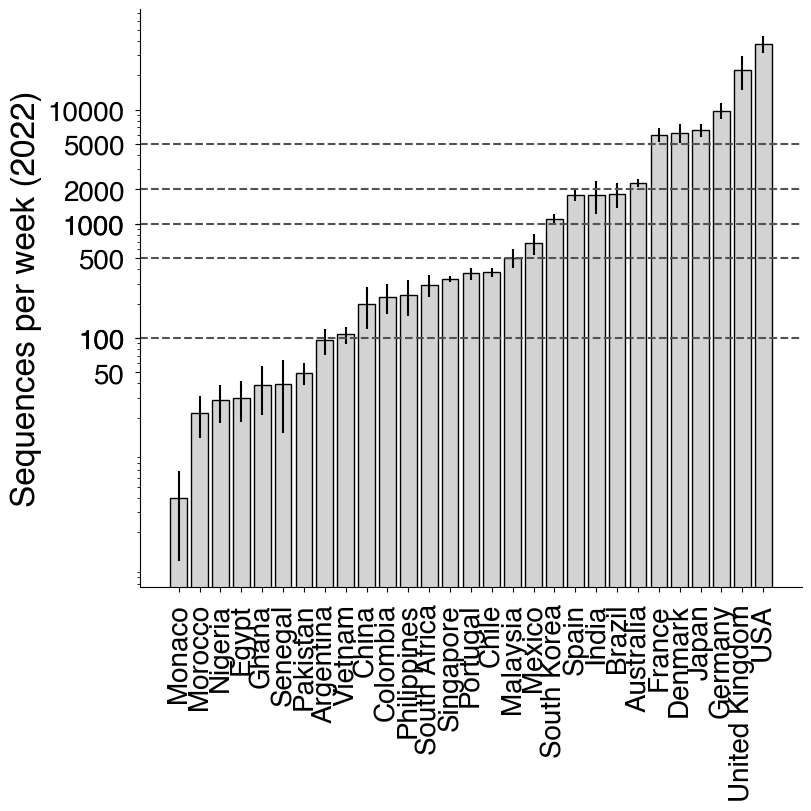

In [5]:
fig = plt.figure(figsize=(8., 8.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(spec[0])

def plot_country_sequencing_rates(ax, plot_df):
    ax.bar(plot_df.country, plot_df.mean_seq_per_week, yerr= 1.96 * plot_df.sem_seq_per_week, 
           ec="k", color="lightgray", error_kw={"elinewidth": 1.5})

    ax.set_yscale("log")
    ax.set_yticks([50, 100, 1000, 10_000] + THRESES)
    ax.set_yticklabels([50, 100, 1000, 10_000] + THRESES)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    for thres in THRESES:
        ax.axhline(y=thres, linestyle ="--", color="#525252", linewidth=1.5)

    ax.set_ylabel("Sequences per week (2022)")
    
plot_country_sequencing_rates(ax, _plot_df)

## Plotting forecast errors

In [6]:
LEADS_TO_PLOT = np.array([-30, -14, 0, 14, 30])
lead_cmap =  mpl.colormaps["Set1"]

In [7]:
errors_df = pd.read_csv("../errors/down_scaled_errors.tsv", sep="\t")

In [8]:
threses = errors_df["thres"].unique()

In [9]:
errors_df.tail()

,location,model,thres,pivot_date,lead,variant,MAE,RMSE,loglik,total_seq,raw_freq,smoothed_freq,pred_freq,date
233907,Germany,MLR,5000,2022-12-01,26,Omicron 21L,0.004440,0.004440,-3.716059,649.0,0.006163,0.006248,0.001807,2022-12-27
233908,Germany,MLR,5000,2022-12-01,27,Omicron 21L,0.005520,0.005520,-1.744304,546.0,0.003663,0.007261,0.001741,2022-12-28
233909,Germany,MLR,5000,2022-12-01,28,Omicron 21L,0.003364,0.003364,-0.912602,544.0,0.000000,0.005040,0.001676,2022-12-29
233910,Germany,MLR,5000,2022-12-01,29,Omicron 21L,0.004071,0.004071,-5.510278,409.0,0.009780,0.005685,0.001613,2022-12-30
233911,Germany,MLR,5000,2022-12-01,30,Omicron 21L,0.004111,0.004111,-8.823160,319.0,0.015674,0.005662,0.001552,2022-12-31


In [10]:
# Filter to three leads of interest
errors = errors_df#[errors_df.lead.isin(DAYS_TO_PLOT_ERROR)]
mean_mae = (errors[["location", "thres", "lead", "pivot_date", "MAE"]] # Why does mean lead differ?
    .groupby(["location", "thres", "lead"])
    .agg({'MAE':['mean','sem']})
    .reset_index()
)
mean_mae.columns = ['location', 'thres', 'lead', 'MAE_mean', 'MAE_sem']

In [11]:
mean_mae[mean_mae.location == "Germany"]

,location,thres,lead,MAE_mean,MAE_sem
1146,Germany,100,-79,0.013602,0.006913
1147,Germany,100,-78,0.014313,0.007551
1148,Germany,100,-77,0.018066,0.009775
1149,Germany,100,-76,0.015765,0.007566
1150,Germany,100,-75,0.016301,0.004774
...,...,...,...,...,...
2295,Germany,5000,26,0.057218,0.015293
2296,Germany,5000,27,0.058603,0.015645
2297,Germany,5000,28,0.060141,0.015910
2298,Germany,5000,29,0.062059,0.016297


In [12]:
def simplify_axes(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

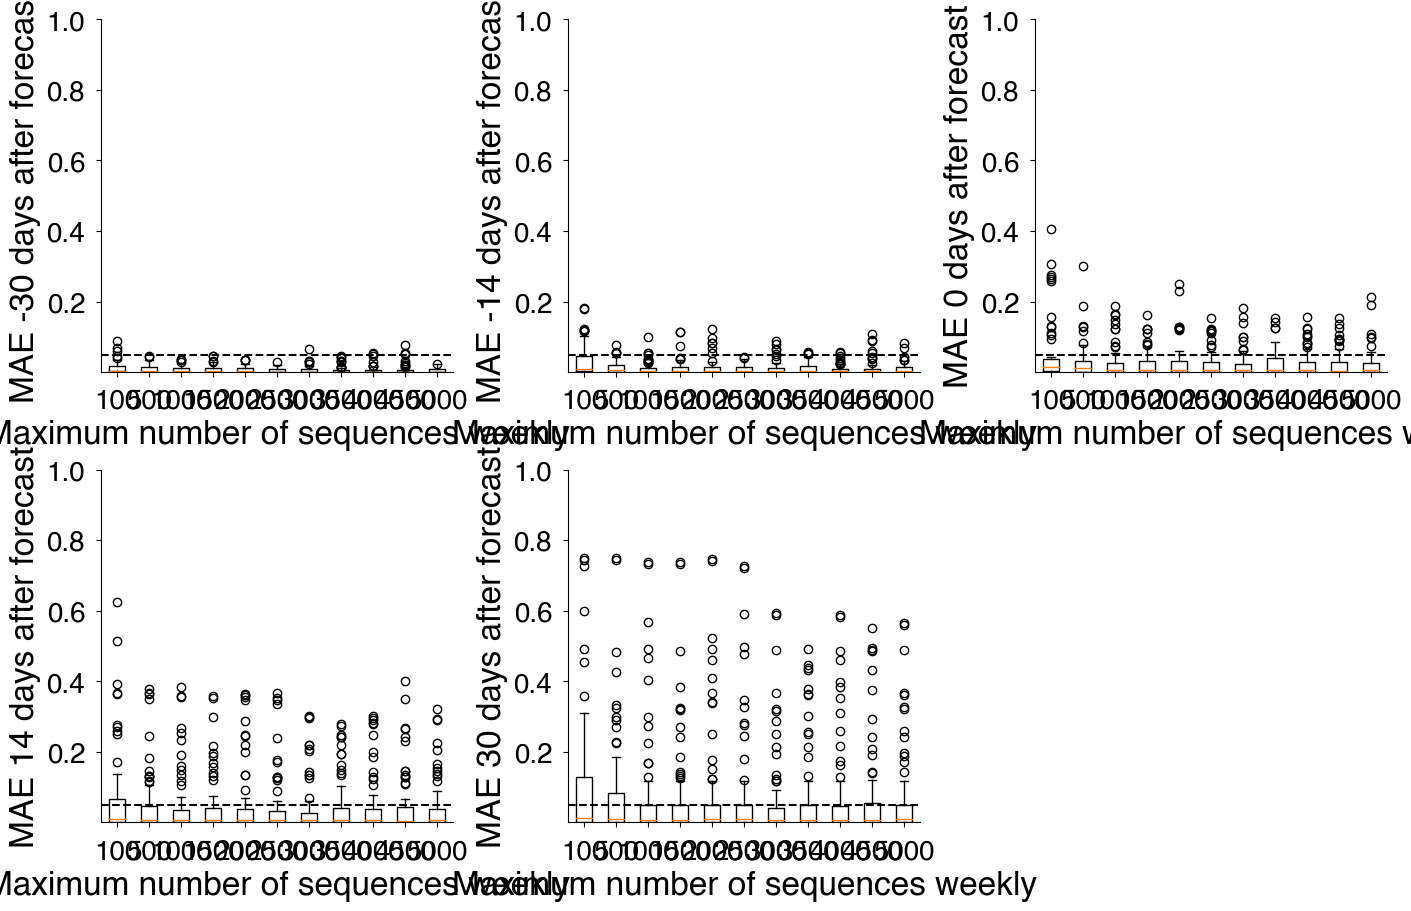

In [13]:
# Plot MAE over lead for each threshold
fig = plt.figure(figsize=(14., 9.), constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=2)

# What should panels be 


def plot_error_by_thres_at_lead(ax, errors, lead, location, ylabel=None):
    _errors = errors.copy()
    if lead is not None:
        _errors = _errors[_errors.lead == lead]
        
    _errors = _errors[_errors.location == location]

    mean_errors_by_thres = _errors.groupby("thres").agg({'MAE':['mean','sem']}).reset_index()    
    ax.plot(_errors.thres, _errors.MAE, ec="k", alpha=0.5)
    ax.errorbar(mean_errors_by_thres.thres, 
                mean_errors_by_thres.MAE["mean"], 
                yerr=2*mean_errors_by_thres.MAE["sem"],
                color="k",
                linewidth=2.5)


    ax.set_xscale("log")
    ax.set_xlabel("Maximum # of sequences weekly")
    ax.set_ylabel(ylabel)
    
def plot_error_by_thres_at_lead(ax, errors, lead, location, ylabel=None, desired_thres=0.05):
    _errors = errors.copy()
    if lead is not None:
        _errors = _errors[_errors.lead == lead]
    
    _errors = _errors[_errors.location == location]

    ax.boxplot([df.MAE for n,df in _errors.groupby("thres")])
    ax.set_xticklabels([n for n,df in _errors.groupby("thres")])
    
    ax.axhline(y=desired_thres, color="k", linestyle="--", linewidth=1.5)
    ax.set_xlabel("Maximum number of sequences weekly")
    ax.set_ylabel(ylabel)

    
for l, lead in enumerate(LEADS_TO_PLOT):
    ax = fig.add_subplot(spec[l])
    
    if l == 0:
        ax0 = ax
    else:
        ax.sharey(ax0)
        
    simplify_axes(ax)
    plot_error_by_thres_at_lead(ax, errors, lead, "United Kingdom", ylabel=f"MAE {lead} days after forecast")
    
    # Changing axes
    #ax.set_yscale("log")
    ax.set_ylim((1e-4, 1.0))
    #ax.set_yticks([0.001, 0.005, 0.05, 0.1, 0.5, 1.0])
    #ax.set_yticklabels(["0.1%", "0.5%", "5%", "10%", "50%", "100%"])

# Change y-axes lo

In [14]:
def plot_error_by_thres(ax, mean_mae, lead, location, ylabel=None):
    _mean_mae = mean_mae.copy()
    if lead is not None:
        _mean_mae = _mean_mae[_mean_mae.lead == lead]
        
    _mean_mae = _mean_mae[_mean_mae.location == location]

    mean_errors_by_thres = _mean_mae.groupby("thres").agg({'MAE_mean':['mean','sem']}).reset_index()    
    ax.scatter(_mean_mae.thres, _mean_mae.MAE_mean, ec="k", alpha=0.3)
    ax.errorbar(mean_errors_by_thres.thres, 
                mean_errors_by_thres.MAE_mean["mean"], 
                #yerr=2*mean_errors_by_thres.MAE_mean["sem"],
                color="k",
                linewidth=2.5)


    ax.set_xscale("log")
    ax.set_xlabel(ylabel)
    ax.set_ylabel("Average MAE over all leads")

In [15]:
threses

array([ 100,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000])

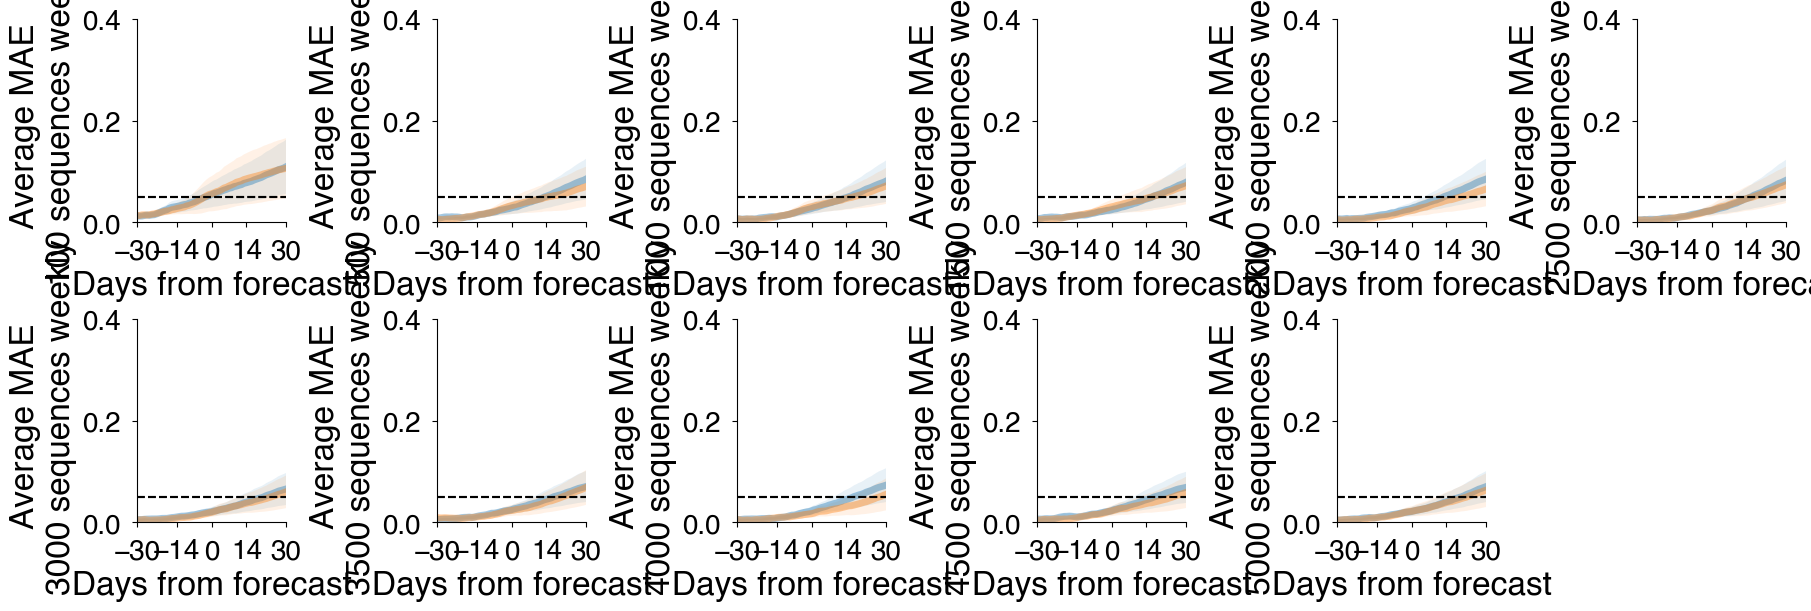

In [16]:
# Plot MAE over lead for each threshold
fig = plt.figure(figsize=(18., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=6, nrows=2)

def plot_error_by_thres(ax, mean_mae, thres, location, ylabel=None, desired_thres=0.05):
    _mean_mae = mean_mae.copy()
    if lead is not None:
        _mean_mae = _mean_mae[_mean_mae.thres == thres]

    _mean_mae = _mean_mae[_mean_mae.location == location]

    ax.plot(_mean_mae.lead, _mean_mae.MAE_mean, alpha=0.4)
    ax.fill_between(_mean_mae.lead, 
                    _mean_mae.MAE_mean - 2*_mean_mae.MAE_sem, 
                    _mean_mae.MAE_mean + 2*_mean_mae.MAE_sem,
                    alpha=0.1)

    ax.set_xlabel("Days from forecast")
    ax.set_ylabel(ylabel)
    ax.axhline(y=desired_thres, color="k", linestyle="--", linewidth=1.5)

for t, thres in enumerate(threses):
    ax = fig.add_subplot(spec[t])
    
    if t == 0:
        ax0 = ax
    else:
        ax.sharey(ax0)
        
    simplify_axes(ax)
    plot_error_by_thres(ax, mean_mae, thres, location="United Kingdom", ylabel=f"Average MAE \n {thres} sequences weekly")
    plot_error_by_thres(ax, mean_mae, thres, location="Germany", ylabel=f"Average MAE \n {thres} sequences weekly")
    
    ax.set_ylim((0.,0.4))
    ax.set_xlim((-30,30))
    ax.set_xticks([-30, -14, 0, 14, 30]) # Can find first point you cross accuracy threshold @ each sequencing thres
    
# Need to repeat for given leads
# Picking thresholds that are like actual historical / country-like rates

# Can we make a companion figure for this that shows what each countries sequencing effort 
# looks like currently in terms of sequences weekly (can tie in colors from rest of manuscript)

In [17]:
# Porportion less than desired_threshold

In [18]:
desired_thres=0.05

errors["acceptable"] = (errors.MAE < desired_thres)

mean_acceptable = (errors[["location", "thres", "lead", "pivot_date", "acceptable"]] # Why does mean lead differ?
    .groupby(["location", "thres", "lead"])
     .agg({'acceptable':['mean','sem']})
    .reset_index()

)
mean_acceptable.columns = ["location", 'thres', 'lead', 'acceptable_mean', 'acceptable_sem']

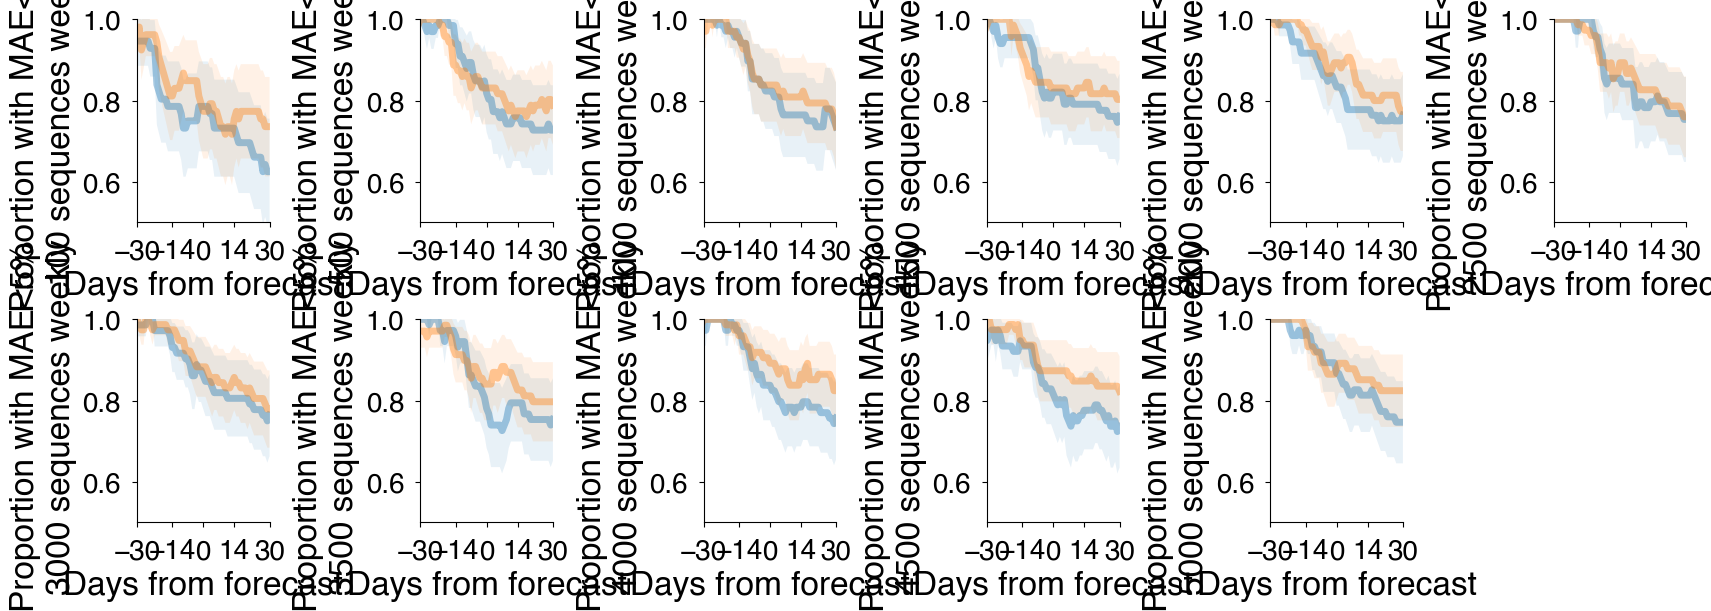

In [19]:
# Plot MAE over lead for each threshold
fig = plt.figure(figsize=(17., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=6, nrows=2)

def plot_accept_by_thres(ax, mean_accept, thres, location, ylabel=None):
    _mean_accept = mean_accept.copy()
    if lead is not None:
        _mean_accept = _mean_accept[_mean_accept.thres == thres]
    
    _mean_accept = _mean_accept[_mean_accept.location == location]

    ax.plot(_mean_accept.lead, _mean_accept.acceptable_mean, alpha=0.4)
    ax.fill_between(_mean_accept.lead, 
                    _mean_accept.acceptable_mean - 2*_mean_accept.acceptable_sem, 
                    _mean_accept.acceptable_mean + 2*_mean_accept.acceptable_sem,
                    alpha=0.1)

    ax.set_xlabel("Days from forecast")
    ax.set_ylabel(ylabel)
    
#ax = fig.add_subplot(spec[0])
for t, thres in enumerate(threses):
    ax = fig.add_subplot(spec[t])
    
    if t == 0:
        ax0 = ax
    else:
        ax.sharey(ax0)
        
    simplify_axes(ax)
    plot_accept_by_thres(ax, mean_acceptable, thres, "United Kingdom", ylabel=f"Proportion with MAE<5% \n {thres} sequences weekly")
    plot_accept_by_thres(ax, mean_acceptable, thres, "Germany", ylabel=f"Proportion with MAE<5% \n {thres} sequences weekly")

    ax.set_ylim((0.5,1.))
    ax.set_xlim((-30,30))
    ax.set_xticks([-30, -14, 0, 14, 30]) # Can find first point you cross accuracy threshold @ each sequencing thres



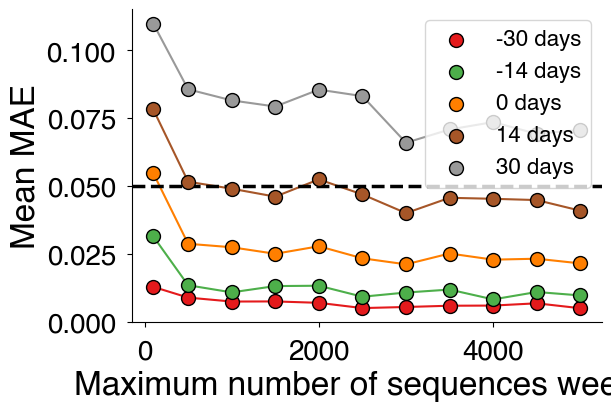

In [20]:
# Thre

# Plot MAE over lead for each threshold
fig = plt.figure(figsize=(6., 4.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(spec[0])

def plot_mae_by_thres_at_lead(ax, mean_mae, leads, location, cmap = mpl.colormaps["plasma"], ylabel=None, desired_thres=0.05, legend=True):
    simplify_axes(ax)
    _mean_mae = mean_mae.copy()
    if leads is not None:
        _mean_mae = _mean_mae[_mean_mae.lead.isin(leads)]
    
    _mean_mae = _mean_mae[_mean_mae.location == location]
    for n, group in _mean_mae.groupby("lead"):        
        color = cmap((n - leads[0]) / (leads[-1] - leads[0]))
        ax.scatter(group.thres, group.MAE_mean, ec="k", label=f"{n} days", color=color, s=100, zorder=3)
        ax.plot(group.thres, group.MAE_mean, linewidth=1.5, color=color)
    ax.axhline(y=desired_thres, color="k", linestyle="--", linewidth=2.5)
    ax.set_xlabel("Maximum number of sequences weekly")
    ax.set_ylabel(ylabel)
    if legend:
        ax.legend()

plot_mae_by_thres_at_lead(ax, mean_mae, LEADS_TO_PLOT, "United Kingdom", cmap=lead_cmap,
                                  ylabel="Mean MAE" )

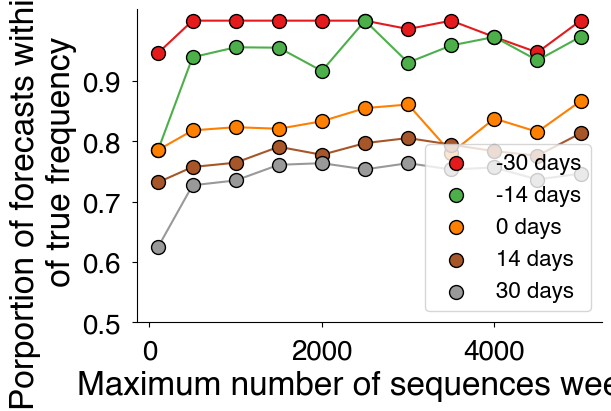

In [21]:
# Threshold is on x-axis, Percent with MAE less than 0.05 is on y-axis?
# At different leads?

# Answers: What number of sequences should pick to ensure our forecast error is less than 0.05 x days out?

# Plot MAE over lead for each threshold
fig = plt.figure(figsize=(6., 4.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(spec[0])

def plot_prop_accept_by_thres_at_lead(ax, mean_accept, leads, location, cmap = mpl.colormaps["plasma"], ylabel=None, desired_thres=0.05, legend=True):
    simplify_axes(ax)
    _mean_accept = mean_accept.copy()
    if leads is not None:
        _mean_accept = _mean_accept[_mean_accept.lead.isin(leads)]
    
    _mean_accept = _mean_accept[_mean_accept.location == location]

    for n, group in _mean_accept.groupby("lead"):
        color = cmap((n - leads[0]) / (leads[-1] - leads[0]))
        ax.scatter(group.thres, group.acceptable_mean, ec="k", label=f"{n} days", color=color, s=100, zorder=3)
        ax.plot(group.thres, group.acceptable_mean, linewidth=1.5, color=color)

    #ax.set_xticklabels([n for n,df in _mean_accept.groupby("thres")])
    #ax.fill_between(_mean_accept.thres, 
    #                _mean_accept.acceptable_mean - 2*_mean_accept.acceptable_sem, 
    #                _mean_accept.acceptable_mean + 2*_mean_accept.acceptable_sem,
    #                alpha=0.1)
    ax.set_xlabel("Maximum number of sequences weekly")
    ax.set_ylabel(ylabel)
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
    if legend:
        ax.legend(loc='lower right')

plot_prop_accept_by_thres_at_lead(ax, mean_acceptable, LEADS_TO_PLOT, "United Kingdom", lead_cmap,
                                  ylabel="Porportion of forecasts within 5%\n of true frequency" )

# Constructing figure

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_6208/2103779884.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


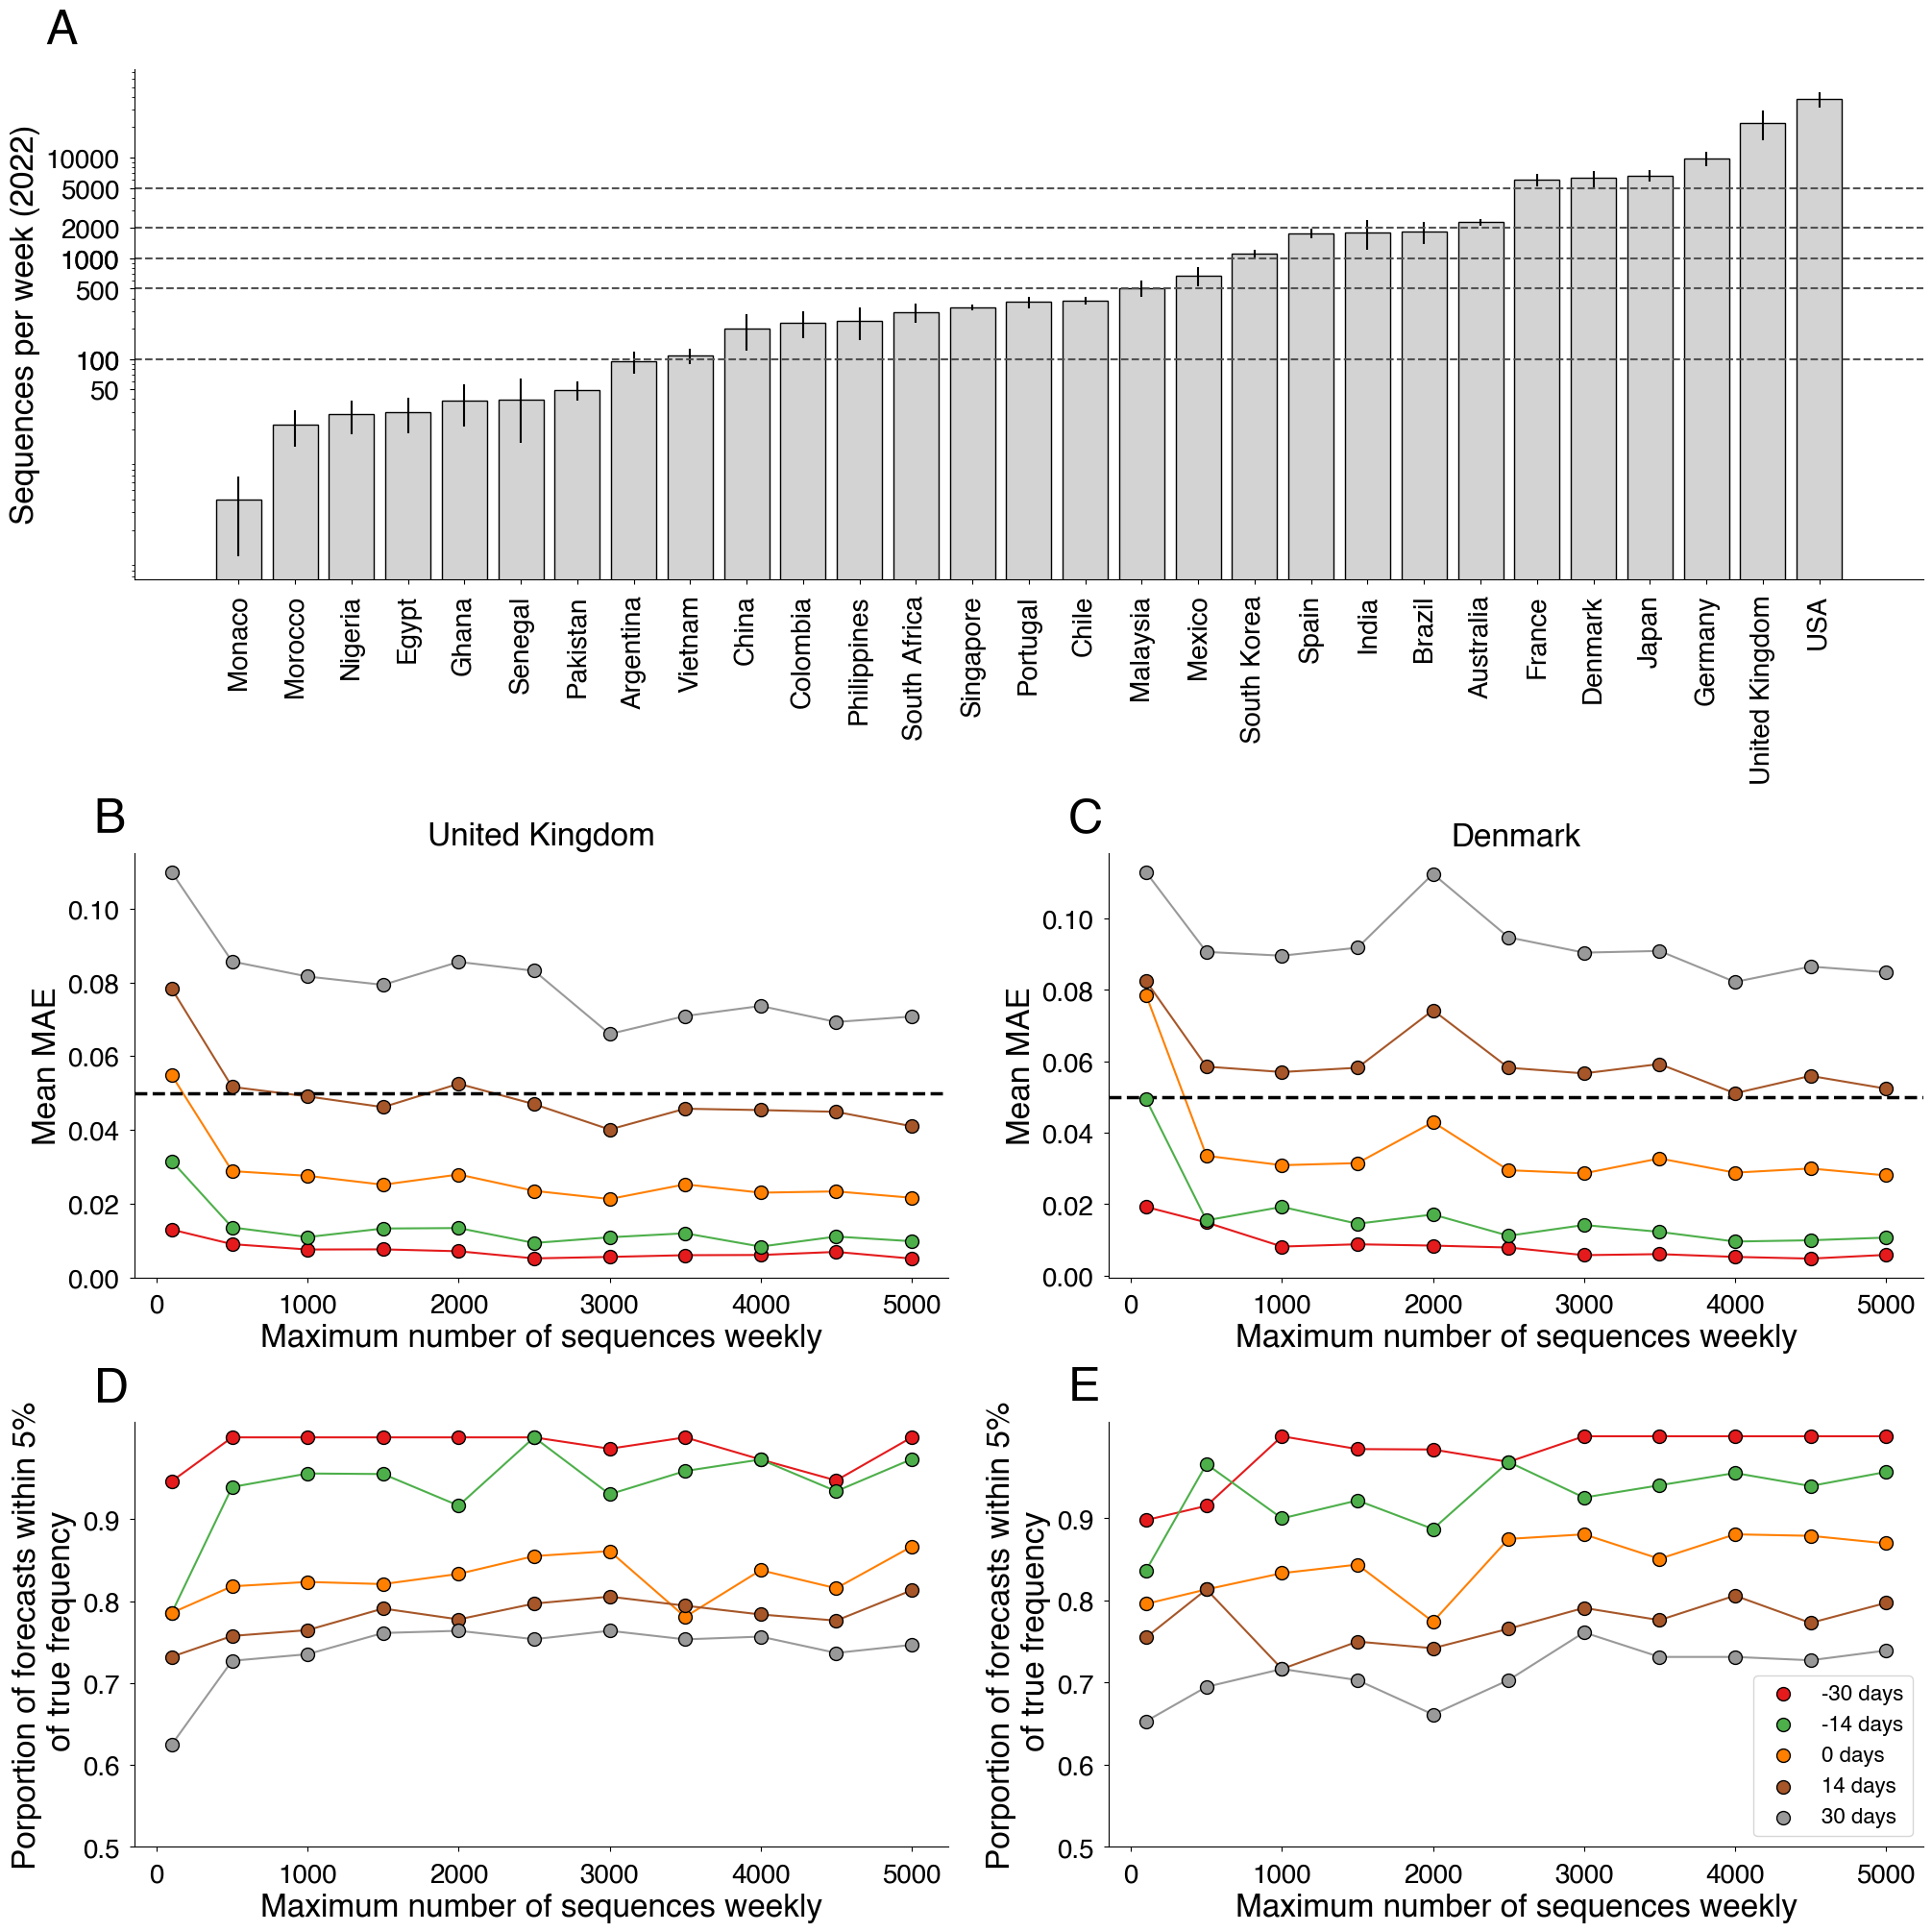

In [22]:
import string 
fig = plt.figure(figsize=(20., 20.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=3, height_ratios=[1.2, 1.0, 1.0])

# Empirical sequencing
ax_empirical = fig.add_subplot(spec[0:2])
plot_country_sequencing_rates(ax_empirical, _plot_df)

COUNTRY_A = "United Kingdom"
COUNTRY_B = "Denmark"
COUNTRY_C = "Germany"

# MAE
ax_mae_A = fig.add_subplot(spec[1,0])
plot_mae_by_thres_at_lead(ax_mae_A, mean_mae, LEADS_TO_PLOT, COUNTRY_A, lead_cmap,
                                  ylabel="Mean MAE", legend=False)
ax_mae_A.set_title(COUNTRY_A)

ax_mae_B = fig.add_subplot(spec[1,1])
plot_mae_by_thres_at_lead(ax_mae_B, mean_mae, LEADS_TO_PLOT, COUNTRY_B, lead_cmap,
                                  ylabel="Mean MAE", legend=False)
ax_mae_B.set_title(COUNTRY_B)

#ax_mae_C = fig.add_subplot(spec[1, 2])
#plot_mae_by_thres_at_lead(ax_mae_C, mean_mae, LEADS_TO_PLOT, COUNTRY_C, lead_cmap,
#                                  ylabel="Mean MAE", legend=False)
#ax_mae_C.set_title(COUNTRY_C)

# Prop acceptable
ax_prop_A = fig.add_subplot(spec[2,0])
plot_prop_accept_by_thres_at_lead(ax_prop_A, mean_acceptable, LEADS_TO_PLOT, COUNTRY_A, lead_cmap,
                                  ylabel="Porportion of forecasts within 5%\n of true frequency", legend=False)

ax_prop_B = fig.add_subplot(spec[2,1])
plot_prop_accept_by_thres_at_lead(ax_prop_B, mean_acceptable, LEADS_TO_PLOT, COUNTRY_B, lead_cmap,
                                  ylabel="Porportion of forecasts within 5%\n of true frequency" )

#ax_prop_C = fig.add_subplot(spec[2,2])
#plot_prop_accept_by_thres_at_lead(ax_prop_C, mean_acceptable, LEADS_TO_PLOT, COUNTRY_C, lead_cmap,
#                                  ylabel="Porportion of forecasts within 5%\n of true frequency" )


# Add axis labels
axes = [ax_empirical, ax_mae_A, ax_mae_B, ax_prop_A, ax_prop_B]

# axes = [ax_empirical, ax_mae_A, ax_mae_B, ax_mae_C, ax_prop_A, ax_prop_B, ax_prop_C]

ax_labels = string.ascii_uppercase 

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.05, 1.05, ax_label, transform=ax.transAxes, size=36, weight='bold')
    
# TODO: Move legend position for panel C

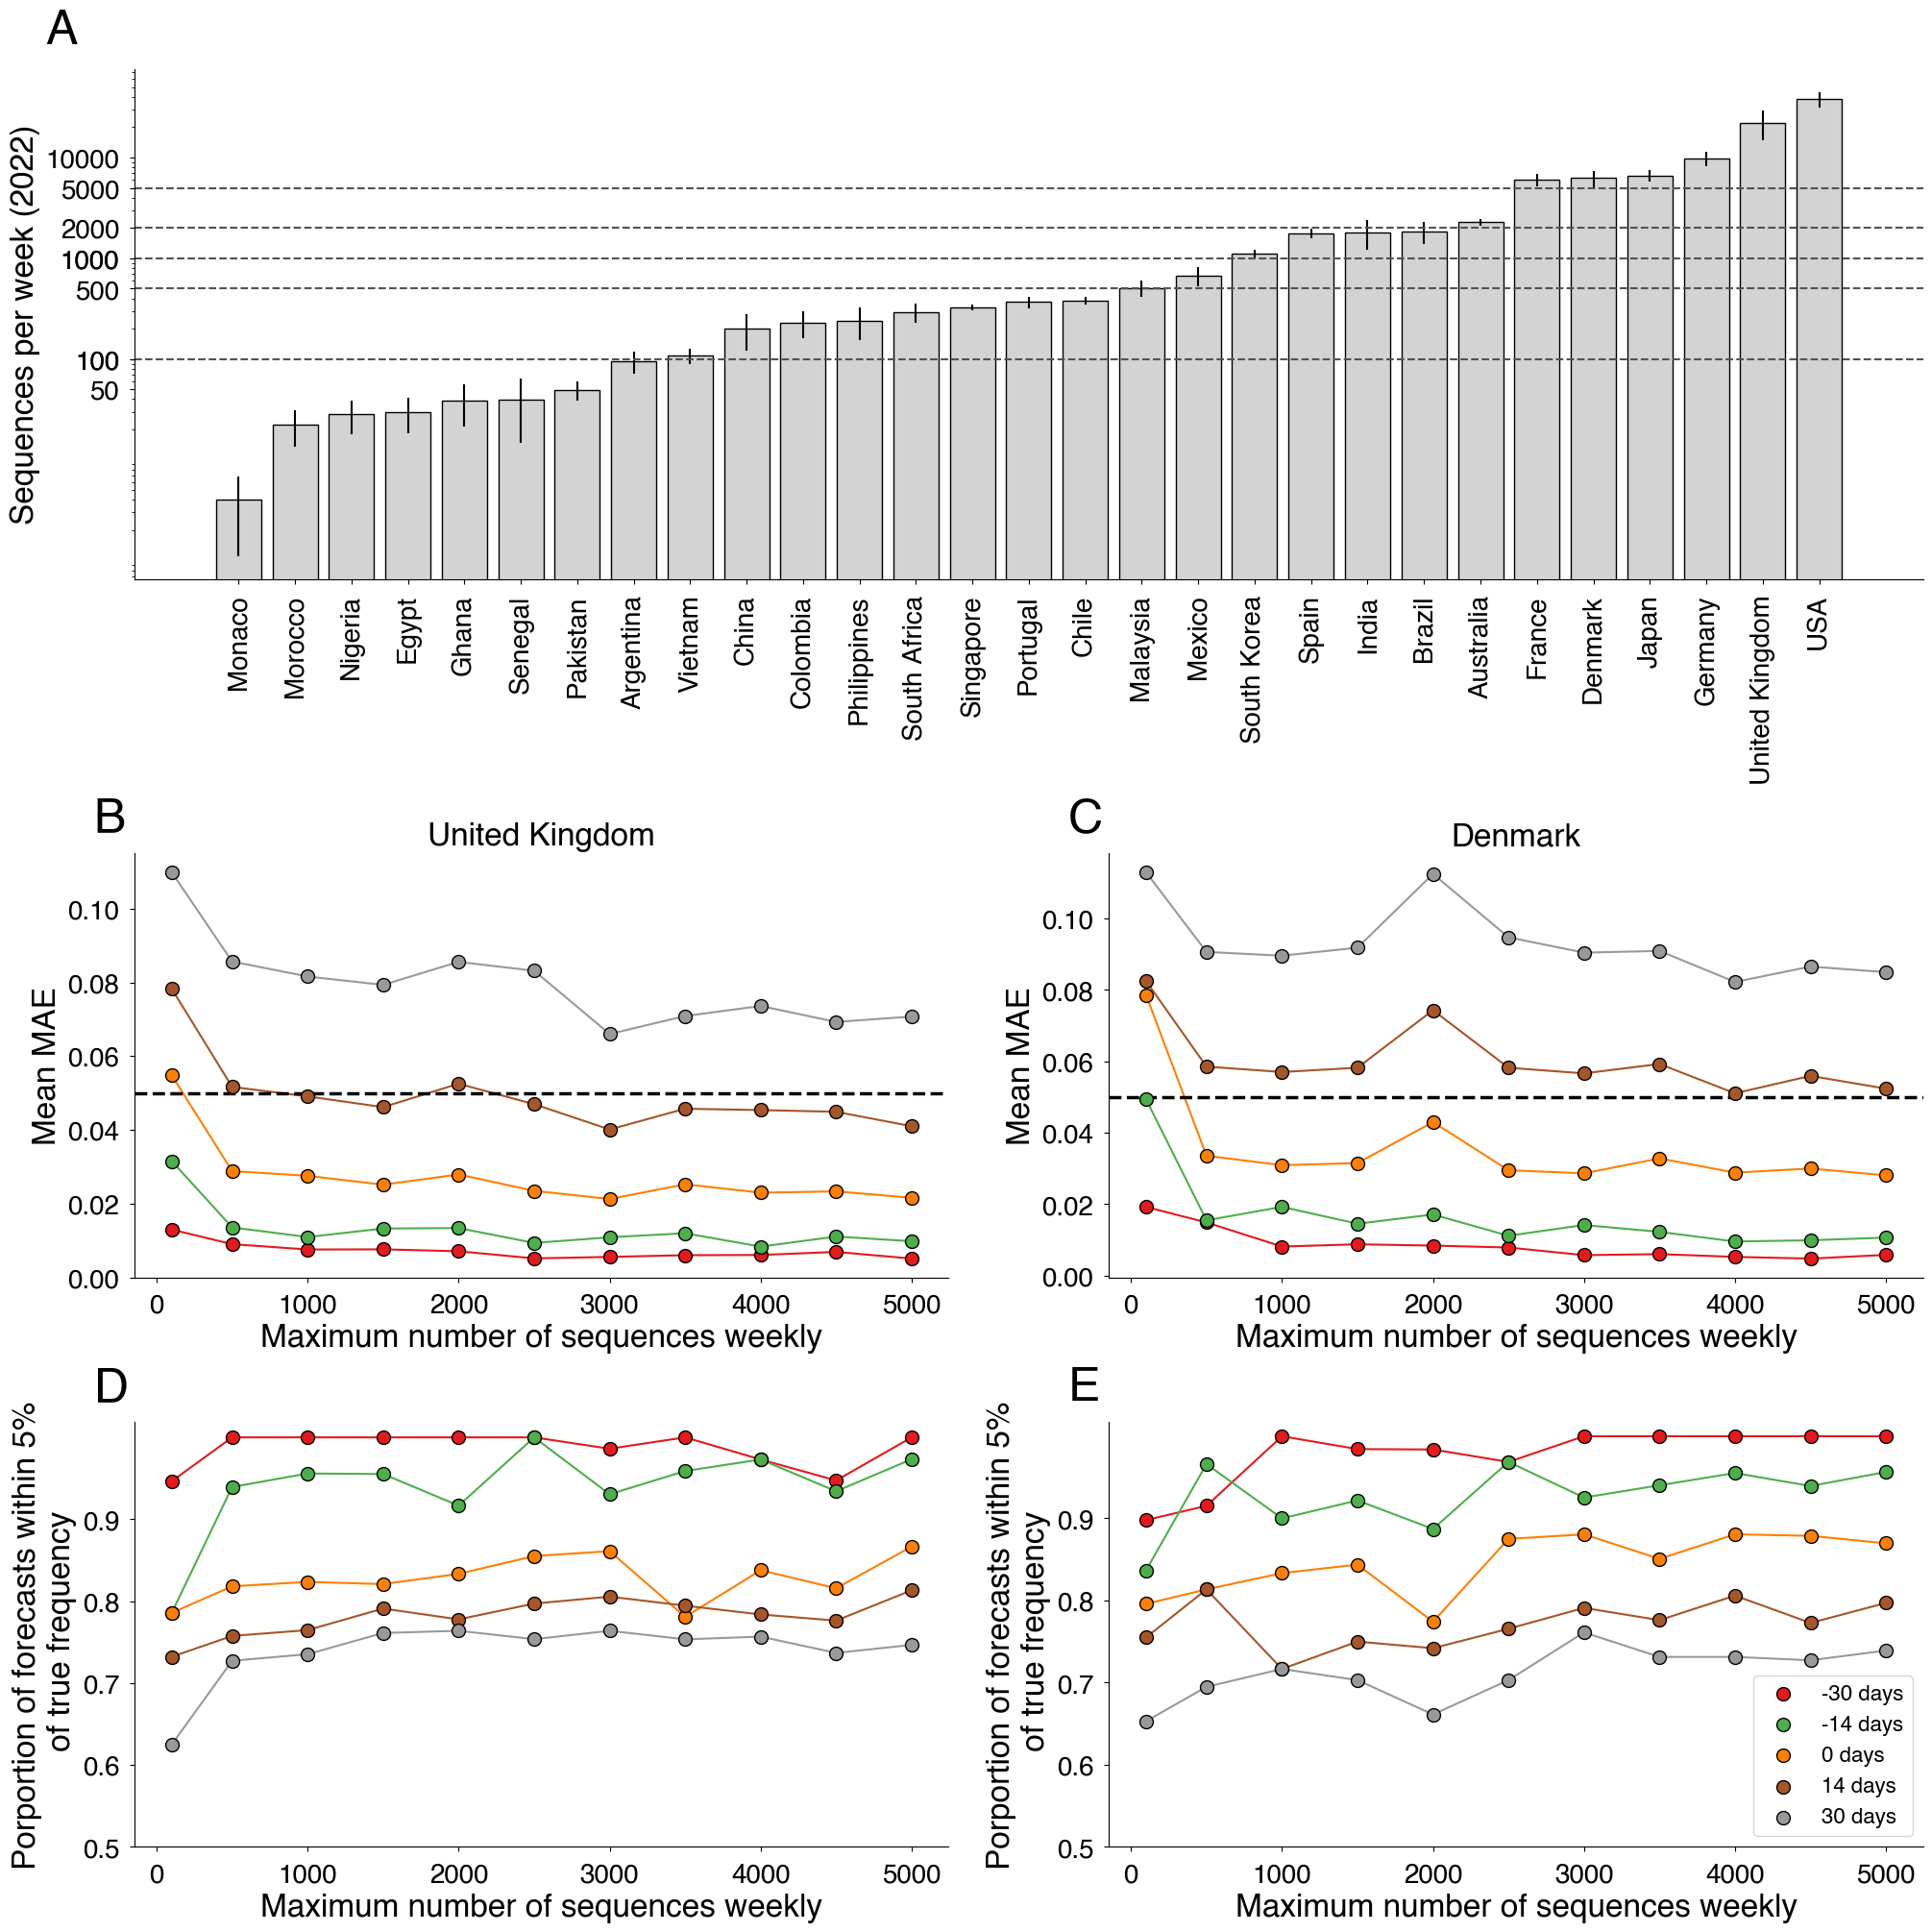

In [23]:
fig

In [24]:
fig.savefig("../manuscript/figures/downscaling_sequencing.png")